# miχpods - TAO

- eulerian 0-40m control volume
- focus on Jq
- use model chl / double exponentials


χpod notes:
- eps = 0 at -39
- 119m in 2015

In [ ]:
%load_ext watermark

import os

import cf_xarray  # nqoa
import dask
import dcpy
import distributed
import flox.xarray
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dcpy
import glob


import pump
from pump import mixpods

dask.config.set({"array.slicing.split_large_chunks": False})
mpl.rcParams["figure.dpi"] = 140
xr.set_options(keep_attrs=True)

gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year/OUTPUT/"  # MITgcm output directory
stationdirname = gcmdir

%watermark -iv

In [ ]:
import dask_jobqueue

if "client" in locals():
    client.close()
    del client
if "cluster" in locals():
    cluster.close()

cluster = dask_jobqueue.PBSCluster(
    cores=4,  # The number of cores you want
    memory="23GB",  # Amount of memory
    processes=1,  # How many processes
    queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory="/local_scratch/pbs.$PBS_JOBID",
    log_directory="/glade/scratch/dcherian/dask/",  # Use your local directory
    resource_spec="select=1:ncpus=4:mem=23GB",  # Specify resources
    project="ncgd0011",  # Input your project ID here
    walltime="02:00:00",  # Amount of wall time
    interface="ib0",  # Interface to use
)
cluster.adapt(minimum_jobs=2, maximum_jobs=8)
# cluster.scale(4)
client = distributed.Client(cluster)
client

In [ ]:
%autoreload

tao_gridded = mixpods.load_tao()
tao_gridded["Ih"] = 0.45 * tao_gridded.swnet * np.exp(-0.04 * np.abs(tao_gridded.mldT))

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "depth" starting at index 42. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "time" starting at index 199726. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


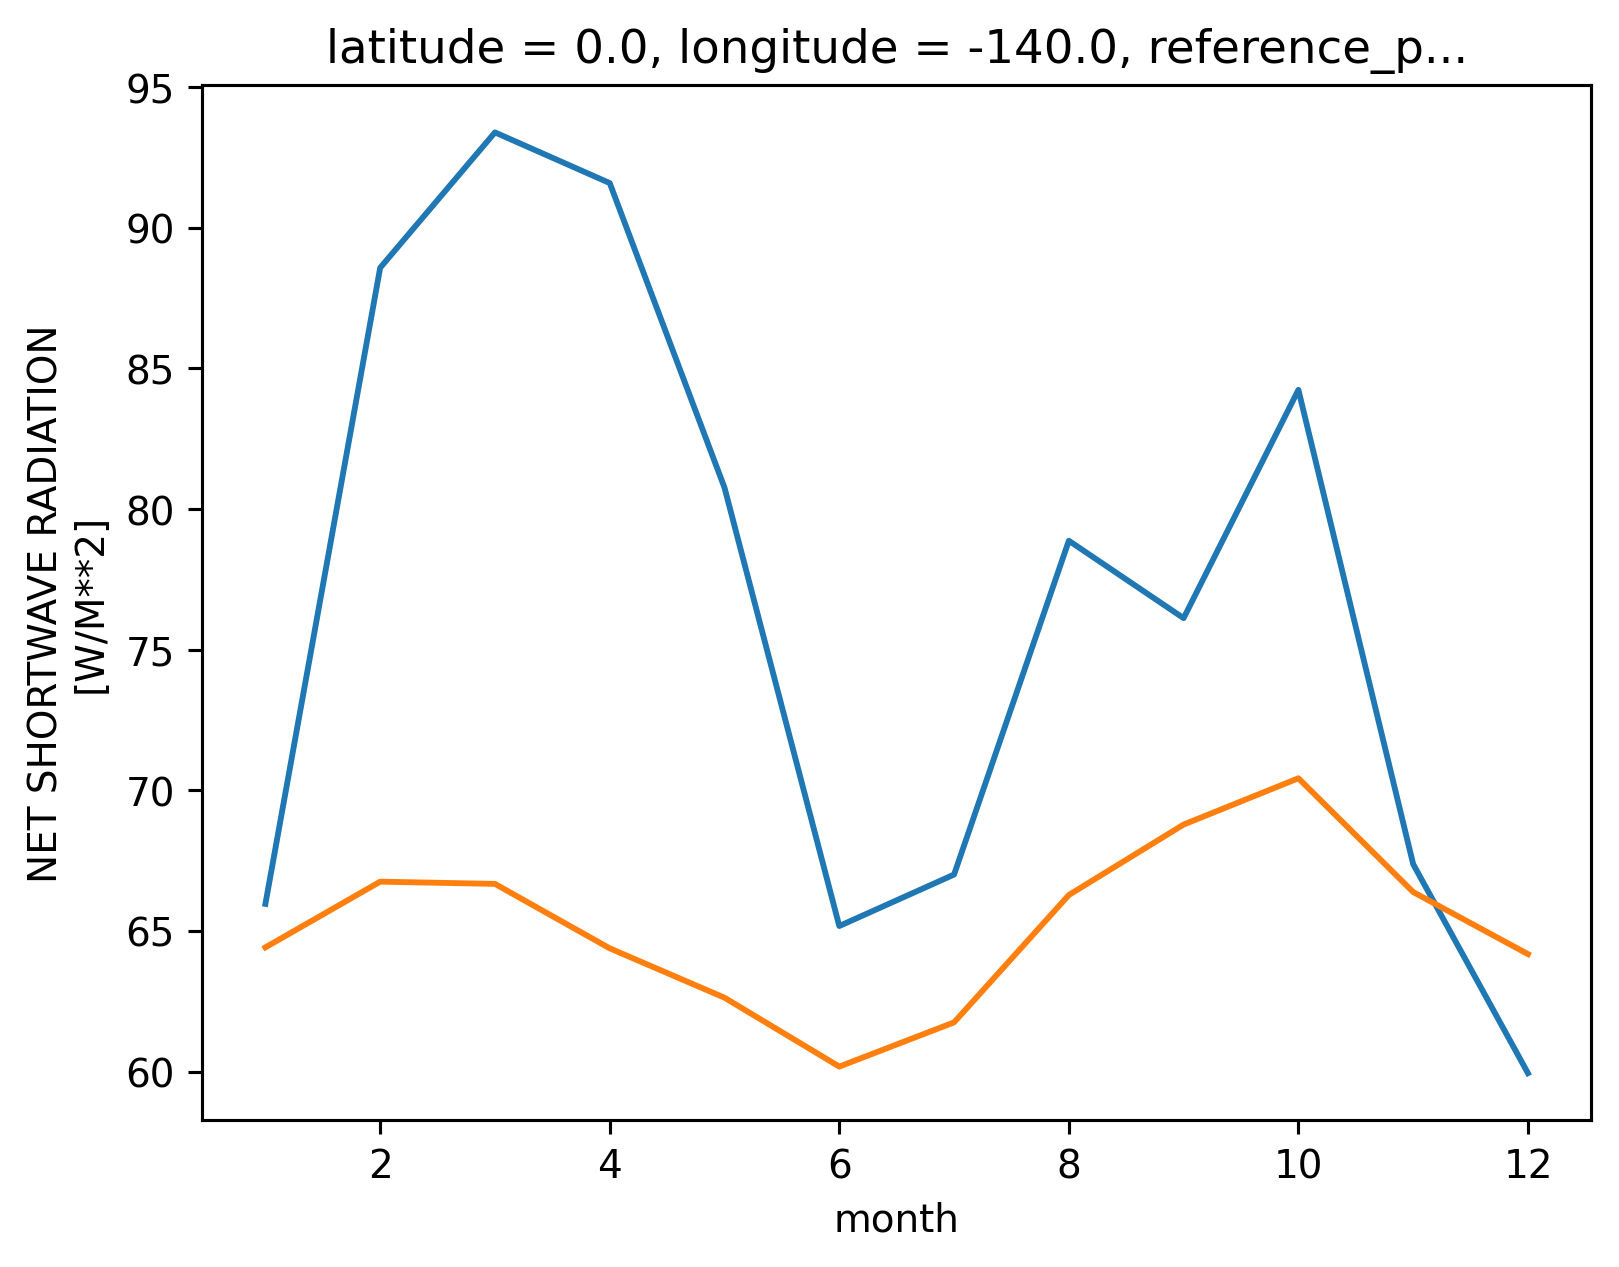

In [ ]:
tao_gridded["Ih"] = 0.45 * tao_gridded.swnet * np.exp(-0.04 * np.abs(tao_gridded.mldT))
tao_gridded.Ih.groupby("time.month").mean().plot()
tao_gridded["Ih"] = 0.45 * tao_gridded.swnet * np.exp(-0.04 * 15)
tao_gridded.Ih.groupby("time.month").mean().plot()

## Check masking

From Sally:
```matlab
ind = find(chihr.time > datenum(2007,1,14,10,25,0),1,'first');
chihr.Jq(3,ind) = NaN;
chihr.eps(3,ind) = NaN;
chihr.Kt(3,ind) = NaN;

ind = find(chihr.time > datenum(2007,1,28,14,25,0),1,'first');
chihr.Jq(4,ind) = NaN;
chihr.eps(4,ind) = NaN;
chihr.Kt(4,ind) = NaN;
```

In [ ]:
%autoreload

chi = mixpods.read_chipod_mat_file(
    os.path.expanduser("~/work/pump/datasets/microstructure/chipods_0_140W_hourly.mat")
)

chi

<xarray.Dataset>
Dimensions:  (depth: 7, time: 128756)
Coordinates:
  * depth    (depth) float64 29.0 39.0 49.0 59.0 69.0 89.0 119.0
  * time     (time) datetime64[ns] 2005-09-23T04:30:00 ... 2020-05-31T23:30:00
Data variables:
    Jq       (time, depth) float64 -4.549 nan -0.0657 nan ... nan nan nan nan
    KT       (time, depth) float64 9.694e-05 nan 1.4e-06 nan ... nan nan nan nan
    N2       (time, depth) float64 3.798e-05 nan 4.135e-05 nan ... nan nan nan
    T        (time, depth) float64 25.56 nan 25.31 nan nan ... nan nan nan nan
    chi      (time, depth) float64 2.708e-08 nan 4.073e-10 nan ... nan nan nan
    dTdz     (time, depth) float64 0.01282 nan 0.01419 nan ... nan nan nan nan
    eps      (time, depth) float64 1.657e-08 nan 2.357e-10 nan ... nan nan nan

In [ ]:
import holoviews as hv

kwargs = dict(groupby="time.year", by="depth", grid=True, aspect=10, frame_height=100)
(
    # chi.chi.hvplot.line(**kwargs, logy=True, ylim=(1e-11, 1e-3))
    chi.eps.hvplot.line(**kwargs, logy=True, ylim=(1e-11, 1e-3))
    + chi.KT.hvplot.line(**kwargs, logy=True, ylim=(1e-11, 10))
    + chi.Jq.hvplot.line(**kwargs)
    + chi.dTdz.hvplot.line(**kwargs)
).opts(
    hv.opts.Overlay(legend_cols=2, legend_position="top"),
    hv.opts.Layout(sizing_mode="stretch_width"),
).cols(
    1
)

:Layout
   .DynamicMap.I   :DynamicMap   [time.year]
      :NdOverlay   [depth]
         :Curve   [time]   (eps)
   .DynamicMap.II  :DynamicMap   [time.year]
      :NdOverlay   [depth]
         :Curve   [time]   (KT)
   .DynamicMap.III :DynamicMap   [time.year]
      :NdOverlay   [depth]
         :Curve   [time]   (Jq)
   .DynamicMap.IV  :DynamicMap   [time.year]
      :NdOverlay   [depth]
         :Curve   [time]   (dTdz)

## ε-Ri histograms

- I think I'm missing some low Ri values.

In [ ]:
%autoreload

tao_gridded = mixpods.load_tao()

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "depth" starting at index 42. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "time" starting at index 199726. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:256: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [ ]:
tao_gridded.update(
    mixpods.pdf_N2S2(tao_gridded.sel(depthchi=slice(-69, -29), time=slice("2017")))
)

<xarray.Dataset>
Dimensions:                (time: 212302, depth: 61, depthchi: 7, N2T_bins: 29,
                            S2_bins: 29, enso_transition_phase: 7, stat: 2,
                            N2_bins: 29, Rig_T_bins: 9)
Coordinates: (12/26)
    deepest                (time) float64 dask.array<chunksize=(212302,), meta=np.ndarray>
  * depth                  (depth) float64 -300.0 -295.0 -290.0 ... -5.0 0.0
    eucmax                 (time) float64 dask.array<chunksize=(33130,), meta=np.ndarray>
    latitude               float32 0.0
    longitude              float32 -140.0
    mld                    (time) float64 dask.array<chunksize=(212302,), meta=np.ndarray>
    ...                     ...
  * S2_bins                (S2_bins) object [-5.0, -4.9) ... [-2.200000000000...
  * enso_transition_phase  (enso_transition_phase) object 'none' ... 'all'
  * stat                   (stat) object 'mean' 'count'
  * N2_bins                (N2_bins) object [-5.0, -4.9) ... [-2.200000000000...
    bin_areas              (N2T_bins, S2_bins) float64 0.01 0.01 ... 0.01 0.01
  * Rig_T_bins             (Rig_T_bins) object (0.025118864315095794, 0.03981...
Data variables: (12/41)
    N2                     (time, depth) float64 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    N2T                    (time, depth) float64 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    Ri                     (time, depth) float64 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    Rig_T                  (time, depth) float64 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    S                      (time, depth) float64 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    S2                     (time, depth) float32 dask.array<chunksize=(33130, 61), meta=np.ndarray>
    ...                     ...
    Tflx_dia_diff          (time, depthchi) float64 nan nan nan ... nan nan nan
    Jb                     (time, depthchi, depth) float64 dask.array<chunksize=(33130, 7, 61), meta=np.ndarray>
    Rif                    (time, depthchi, depth) float64 dask.array<chunksize=(33130, 7, 61), meta=np.ndarray>
    n2s2pdf                (N2T_bins, S2_bins, enso_transition_phase) float64 dask.array<chunksize=(29, 29, 1), meta=np.ndarray>
    eps_n2s2               (stat, N2_bins, S2_bins, enso_transition_phase) float64 dask.array<chunksize=(1, 29, 29, 7), meta=np.ndarray>
    eps_ri                 (stat, Rig_T_bins, enso_transition_phase) float64 dask.array<chunksize=(1, 9, 1), meta=np.ndarray>
Attributes:
    CREATION_DATE:                23:26 24-FEB-2021
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    _FillValue:                   1.0000000409184788e+35
    array:                        TAO/TRITON
    missing_value:                1.0000000409184788e+35
    platform_code:                0n165e
    site_code:                    0n165e
    wmo_platform_code:            52321

In [ ]:
def plot_eps_ri_hist(eps_ri):
    import pandas as pd
    import hvplot.pandas

    intervals = pd.Index(pd.arrays.IntervalArray(eps_ri.Rig_T_bins.data)).mid

    eps_ri = eps_ri.copy()
    eps_ri["Rig_T_bins"] = intervals

    # df = eps_ri.load().sel(
    #    stat="mean", enso_transition_phase=["La-Nina cool", "El-Nino warm"]
    # ).to_dataframe()
    # new_midx = pd.MultiIndex.from_product(
    #    [intervals, ["La-Nina cool", "El-Nino warm"]],
    #    names=["Rig_T_bins", "enso_transition_phase"]),
    # df.index = new_midx

    step = (
        eps_ri.sel(stat="mean")
        .sel(
            enso_transition_phase=[
                "El-Nino warm",  # "El-Nino cool",
                "La-Nina cool",
                # "La-Nina warm"
            ]
        )
        .hvplot.step(
            frame_width=600,
            frame_height=300,
            col="enso_transition_phase",
            x="Rig_T_bins",
            logx=True,
            logy=True,
        )
    )

    return step.opts(
        hv.opts.Curve(xlim=(None, 1.2), xticks=[0.04, 0.1, 0.25, 0.5, 0.63, 1.6])
    )


plot_eps_ri_hist(tao_gridded.eps_ri)

:GridSpace   [enso_transition_phase]
   :Curve   [Rig_T_bins]   (eps_ri)

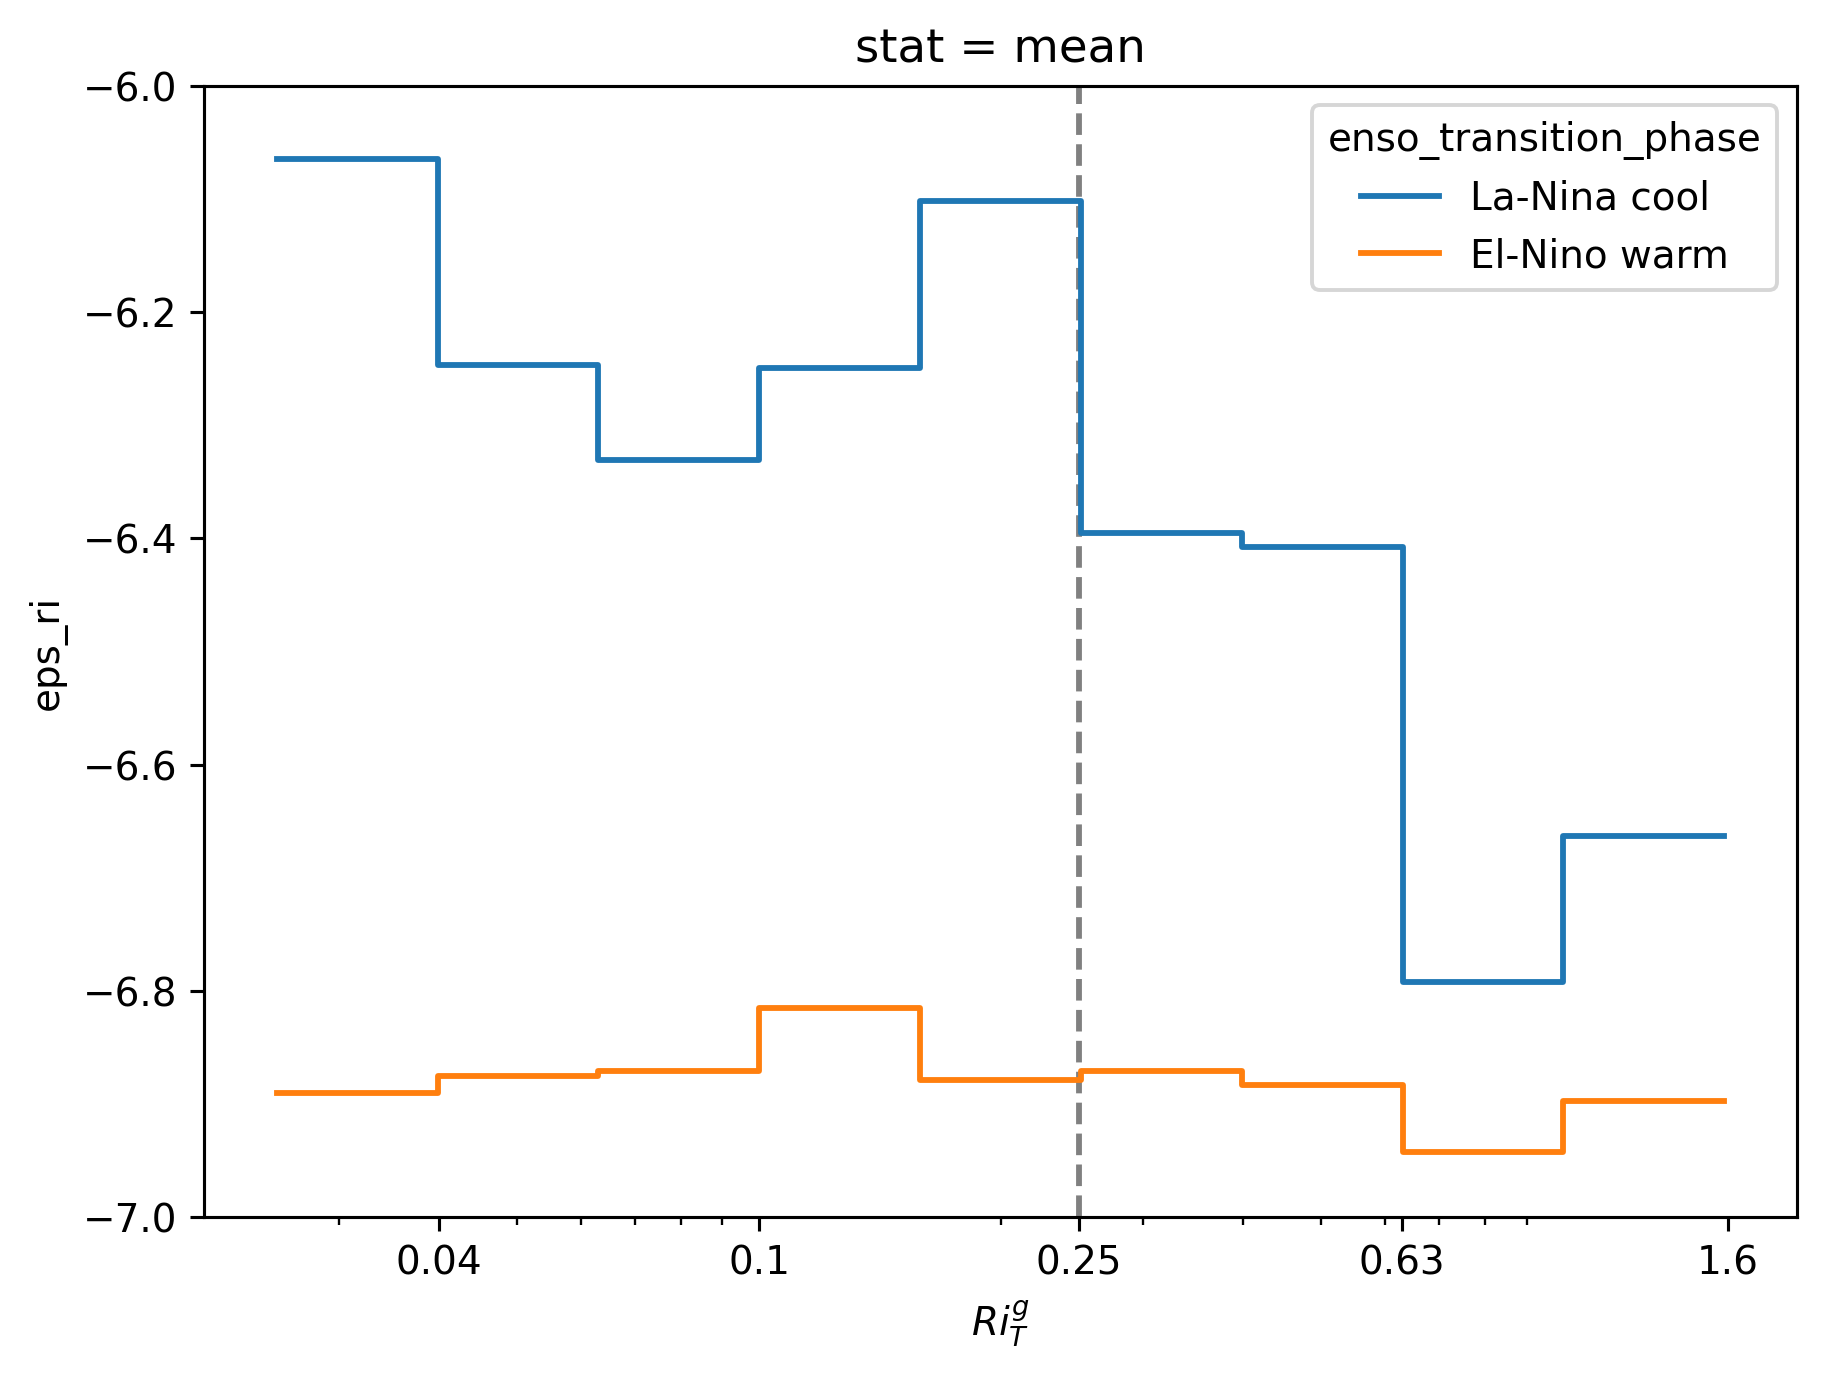

In [ ]:
%autoreload

newda = xr.DataArray(
    np.log10(
        tao_gridded.eps_ri.sel(
            enso_transition_phase=["La-Nina cool", "El-Nino warm"], stat="mean"
        )
    )
)

f, ax = plt.subplots(1, 1, constrained_layout=True)
newda.plot.step(hue="enso_transition_phase", xscale="log", ylim=(-7, -6))
ticks = [0.04, 0.1, 0.25, 0.63, 1.6]
ax.set_xticks(ticks)
ax.set_xticklabels([0.04, 0.1, 0.25, 0.63, 1.6])
dcpy.plots.linex(0.25)

## Moum et al (2013) Climatologies

- The published .nc file seems “over cleaned" with mask ε < 3e-6 or so

In [ ]:
tropflux = xr.open_mfdataset(
    sorted(glob.glob("/glade/work/dcherian/datasets/tropflux/**/*.nc")),
    engine="netcdf4",
    parallel=True,
)

tropflux_0140 = tropflux.interp(latitude=0, longitude=360 - 140).load()
tropflux_clim = tropflux_0140.groupby("time.month").mean()

### Monthly climatology, Vertical mean

#### Didn't work with published nc file

[<matplotlib.lines.Line2D>]

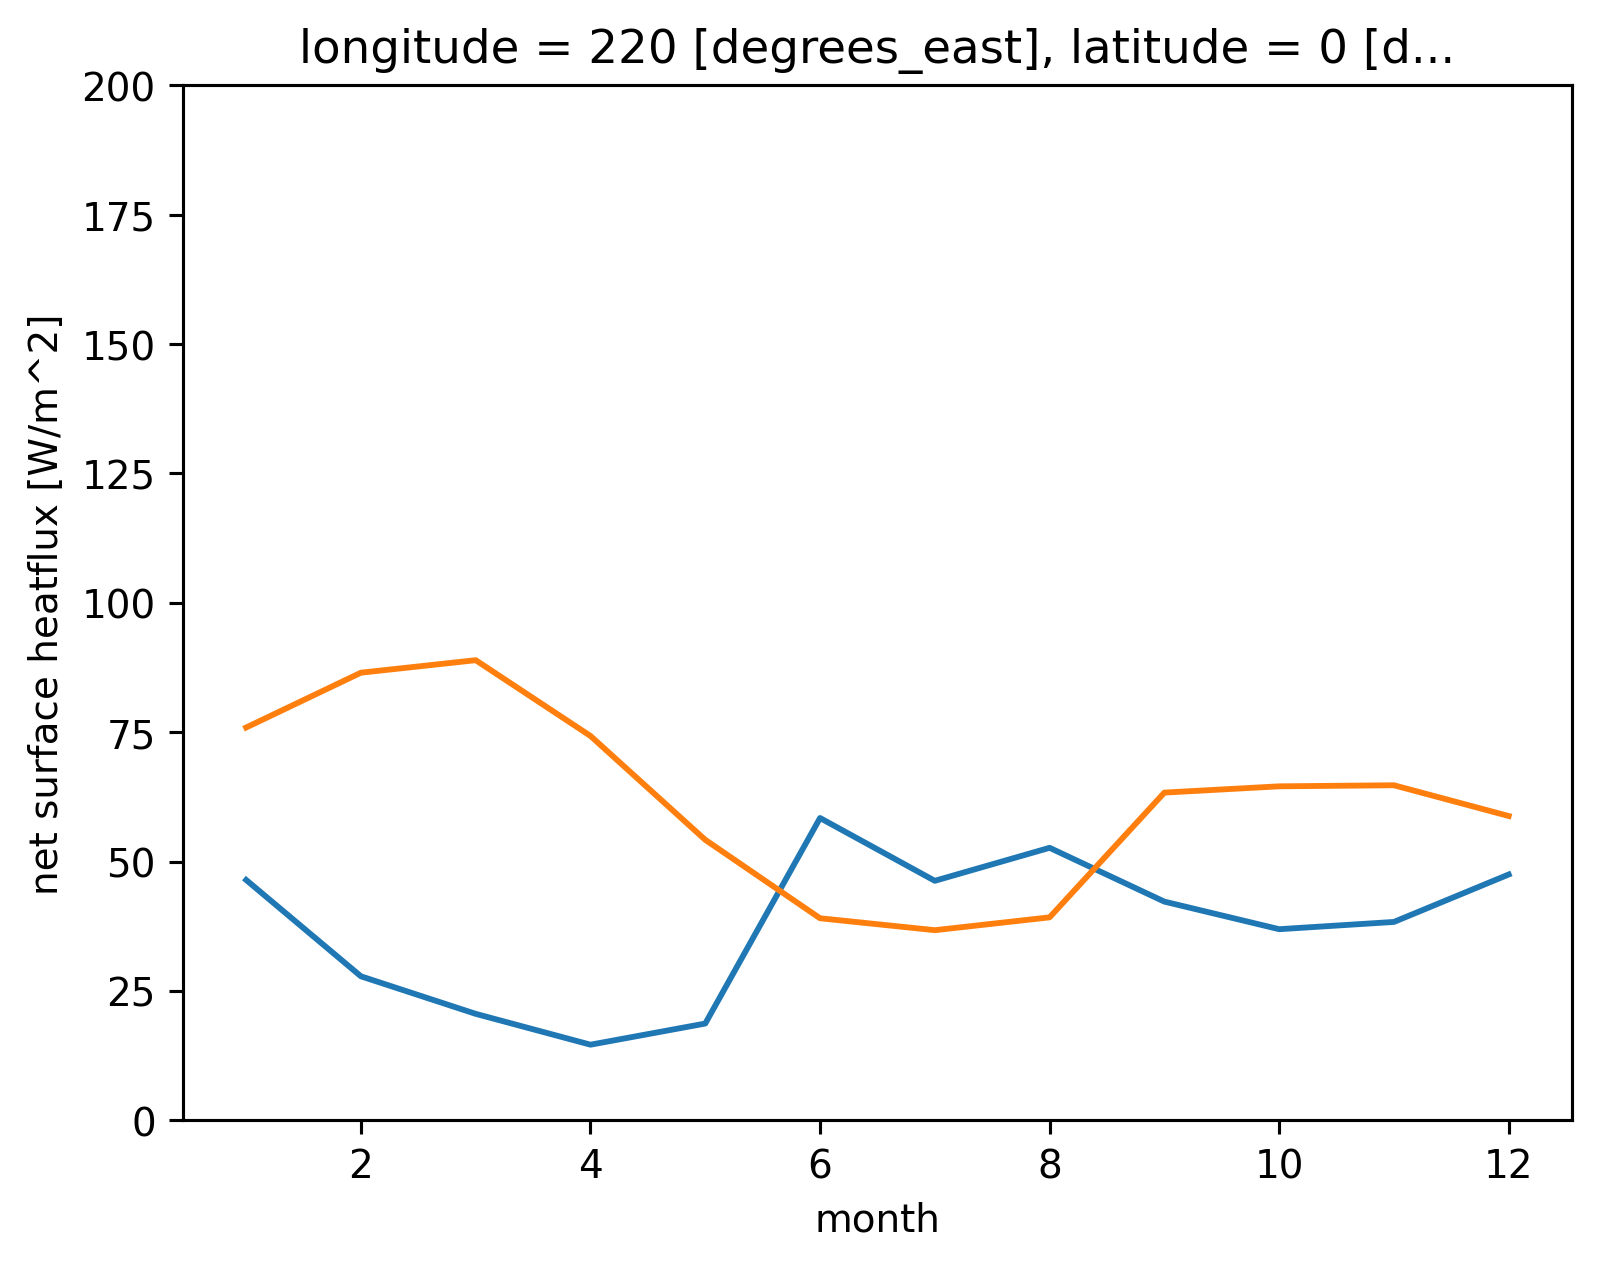

In [ ]:
clim = xr.Dataset()
clim["netflux"] = (
    tropflux_0140.netflux.sel(time=slice("2005", "2011")).groupby("time.month").mean()
)
clim["Ih"] = tao_gridded.Ih.sel(time=slice("2005", "2011")).groupby("time.month").mean()
clim["Jq"] = (
    tao_gridded.Jq.sel(time=slice("2005", "2011"), depthchi=slice(-60, -20))
    .groupby("time.month")
    .mean(["depthchi", "time"])
)

(-1 * clim.Jq).plot(ylim=(0, 200))
(clim.netflux - clim.Ih).plot(ylim=(0, 200))

#### Try with .mat file

In [ ]:
cchdo = dcpy.oceans.read_cchdo_chipod_file(
    "/glade/u/home/dcherian/datasets/microstructure/osu/chipod/tao/chipods_0_140W.nc"
)
cchdo

<xarray.Dataset>
Dimensions:     (depth: 7, time: 107588)
Coordinates:
    timeSeries  (depth) float64 ...
  * time        (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:2...
    lat         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
    lon         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
  * depth       (depth) float64 29.0 39.0 49.0 59.0 69.0 89.0 119.0
Data variables:
    T           (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    dTdz        (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    N2          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    KT          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    chi         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    eps         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    Jq          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
Attributes: (12/68)
    ncei_template_version:           NCEI_NetCDF_TimeSeries_Orthogonal_Templa...
    featureType:                     timeSeries
    title:                           Turbulence quantities measured by chipod...
    summary:                         Turbulence data in upper w m / all good ...
    keywords:                        sea_water_temperature, square_of_brunt_v...
    Conventions:                     CF-1.6, ACDD-1.3
    ...                              ...
    reference8:                      Moum, J.N., Ocean speed and turbulence m...
    reference9:                      Warner, S.J., J. Becherer, K. Pujiana, E...
    reference10:                     Moum, J.N., K. Pujiana, R-C. Lien and W....
    reference11:                     Becherer, J. and J.N. Moum, An efficient...
    reference12:                     Moulin, A.J., J.N. Moum and E.L. Shroyer...
    reference13:                     Thakur, R., E.L. Shroyer, R. Govindaraja...

In [ ]:
mat = mixpods.read_chipod_mat_file(
    os.path.expanduser("~/work/pump/datasets/microstructure/chipods_0_140W_hourly.mat")
)

In [ ]:
mat.Jq.where(np.abs(mat.Jq) < 10000).groupby("time.year").mean().sel(
    year=slice(2005, 2011)
).hvplot.line(
    by="year", y="depth", flip_yaxis=True
)  # .opts(legend_cols=1)

:NdOverlay   [year]
   :Curve   [Jq]   (depth)

#### Compare

In [ ]:
h1 = (
    cchdo.Jq.reset_coords(drop=True)
    .resample(time="M")
    .mean()
    .hvplot.quadmesh(
        cmap="greys",
        flip_yaxis=True,
        frame_width=1200,
        frame_height=200,
        clim=(40, -100),
    )
)
h2 = (
    mat.Jq.resample(time="M")
    .mean()
    .hvplot.quadmesh(
        cmap="greys",
        flip_yaxis=True,
        frame_width=1200,
        frame_height=200,
        clim=(40, -100),
    )
)

In [ ]:
(h2.opts(title=".mat") + h1.opts(title="CCHDO")).cols(1)

:Layout
   .QuadMesh.I  :QuadMesh   [time,depth]   (Jq)
   .QuadMesh.II :QuadMesh   [time,depth]   (Jq)

In [ ]:
h = (
    (
        np.abs(cchdo.Jq.resample(time="D").mean())
        .reset_coords(drop=True)
        .hvplot.line(by="depth", x="time")
        .opts(frame_width=1200)
        + np.abs(mat.Jq.resample(time="D").mean())
        .reset_coords(drop=True)
        .hvplot.line(by="depth", x="time")
        .opts(frame_width=1200)
    )
    .opts(shared_axes=True)
    .cols(1)
)
h

:Layout
   .NdOverlay.I  :NdOverlay   [depth]
      :Curve   [time]   (Jq)
   .NdOverlay.II :NdOverlay   [depth]
      :Curve   [time]   (Jq)

In [ ]:
def plot_monthly_clim(ds, **kwargs):
    return np.abs(
        ds.Jq.sel(time=slice("2005", "2011-02"))
        .sel(depth=slice(20, 60))
        .mean("depth")
        .groupby("time.month")
        .mean()
    ).hvplot.line(**kwargs)


(
    plot_monthly_clim(mat, label=".mat")
    * plot_monthly_clim(mat.where(np.abs(mat.Jq) < 20000), label=".mat, Jq < 20000")
    * plot_monthly_clim(mat.where(np.abs(mat.Jq) < 10000), label=".mat, Jq < 10000")
    * plot_monthly_clim(mat.where(np.abs(mat.Jq) < 3000), label=".mat, Jq < 3000")
    * plot_monthly_clim(mat.where(mat.eps < 5e-4), label=".mat, ε < 5e-4")
    * plot_monthly_clim(mat.where(mat.eps < 1e-5), label=".mat, ε < 1e-5")
    * plot_monthly_clim(mat.where(mat.eps < 3e-6), label=".mat, ε < 3e-6")
    * plot_monthly_clim(cchdo, label="CCHDO", color="k")
    * (clim.netflux - clim.Ih)
    .rename("a")
    .hvplot.line(label="Jq0 - Ih", color="k", line_width=4)
).opts(show_grid=True, legend_position="right", frame_width=600, ylim=(0, 160))

:Overlay
   .Curve.Full_stop_mat                                     :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_Jq_less_than_20000            :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_Jq_less_than_10000            :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_Jq_less_than_3000             :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_ε_less_than_5e_hyphen_minus_4 :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_ε_less_than_1e_hyphen_minus_5 :Curve   [month]   (Jq)
   .Curve.Full_stop_mat_comma_ε_less_than_3e_hyphen_minus_6 :Curve   [month]   (Jq)
   .Curve.CCHDO                                             :Curve   [month]   (Jq)
   .Curve.Jq0_hyphen_minus_Ih                               :Curve   [month]   (a)

### Seasonal climatology, Vertical profile

In [ ]:
def plot_seasonal_clim(ds, **kwargs):
    return (
        np.abs(
            ds.Jq.sel(time=slice("2005", "2011-02"))
            .sel(depth=slice(20, 70))
            # .mean("depth")
            .groupby("time.season")
            .mean()
            .sel(season=["DJF", "MAM", "JJA", "SON"])
        ).hvplot.line(flip_yaxis=True, y="depth", col="season", **kwargs)
        # .opts()
    )


h = (
    plot_seasonal_clim(mat, label=".mat")
    * plot_seasonal_clim(mat.where(mat.eps < 1e-4), label=".mat, ε < 1e-4")
    * plot_seasonal_clim(mat.where(mat.eps < 1e-5), label=".mat, ε < 1e-5")
    * plot_seasonal_clim(mat.where(mat.eps < 3e-6), label=".mat, ε < 3e-6")
    * plot_seasonal_clim(cchdo, label="CCHDO", color="k")
)
h.opts(plot_size=(270, 350), shared_xaxis=True, shared_yaxis=True, show_legend=True)

:GridSpace   [season]
   :Overlay
      .Curve.Full_stop_mat                                     :Curve   [Jq]   (depth)
      .Curve.Full_stop_mat_comma_ε_less_than_1e_hyphen_minus_4 :Curve   [Jq]   (depth)
      .Curve.Full_stop_mat_comma_ε_less_than_1e_hyphen_minus_5 :Curve   [Jq]   (depth)
      .Curve.Full_stop_mat_comma_ε_less_than_3e_hyphen_minus_6 :Curve   [Jq]   (depth)
      .Curve.CCHDO                                             :Curve   [Jq]   (depth)

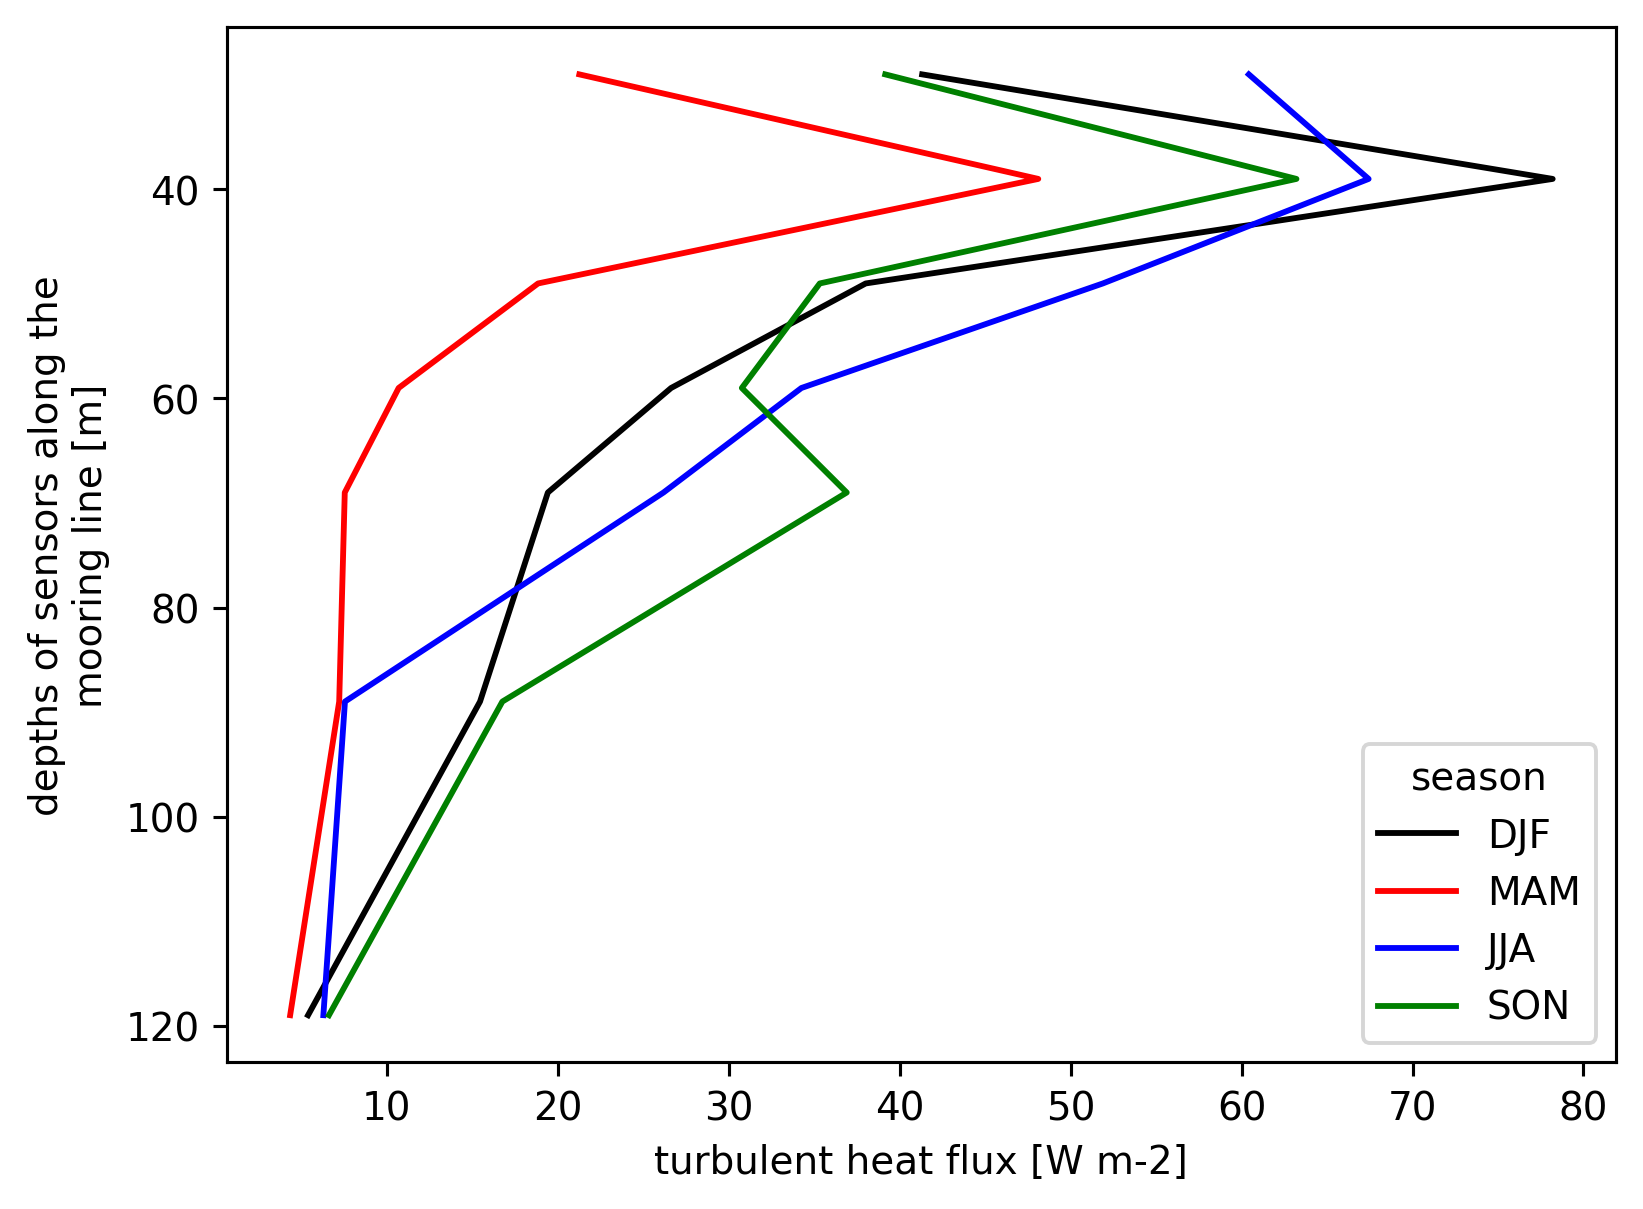

In [ ]:
from cycler import cycler

with plt.rc_context({"axes.prop_cycle": cycler(color=["k", "r", "b", "g"])}):
    (
        (-1 * cchdo.Jq.where(cchdo.Jq > -1e3).squeeze())
        .sel(time=slice("2005", "2012-02-01"))
        .groupby("time.season")
        .mean()
        .sel(season=["DJF", "MAM", "JJA", "SON"])
        .cf.plot(y="depth", hue="season")
    )

## Labeling ENSO phase transitions

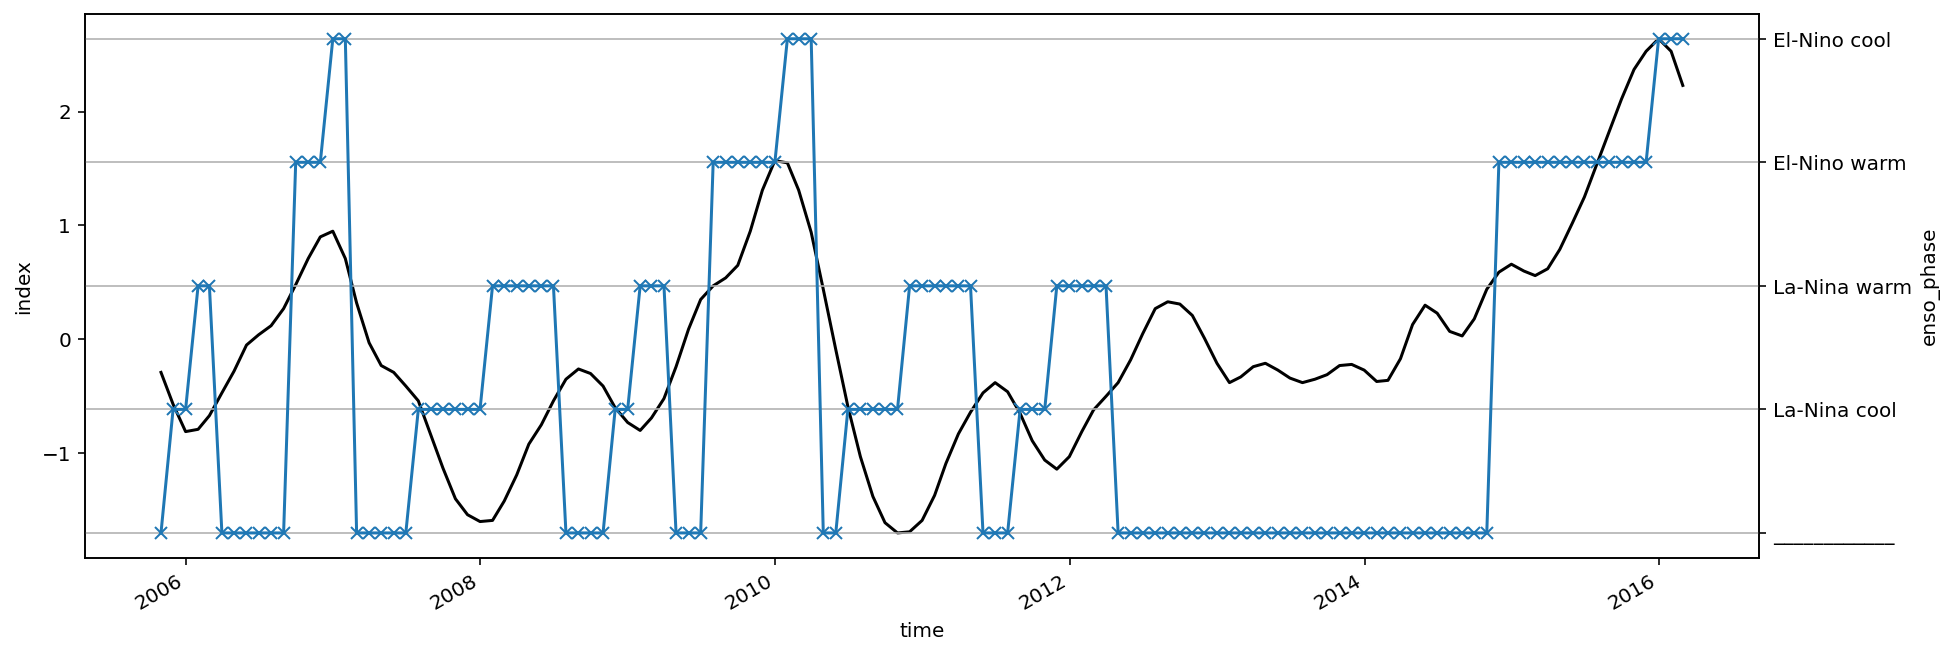

In [ ]:
pump.obs.process_oni().sel(time=slice("2005-Oct", "2016-Feb")).reset_coords(
    drop=True
).plot.line(aspect=3, size=5, color="k")
pump.obs.make_enso_transition_mask().sel(
    time=slice("2005-Oct", "2016-Feb")
).reset_coords(drop=True).plot.line(ax=plt.gca().twinx(), marker="x")
plt.grid(True, which="both", axis="both")

## N2 vs N2T

Lot more data with N2T

<matplotlib.collections.QuadMesh>

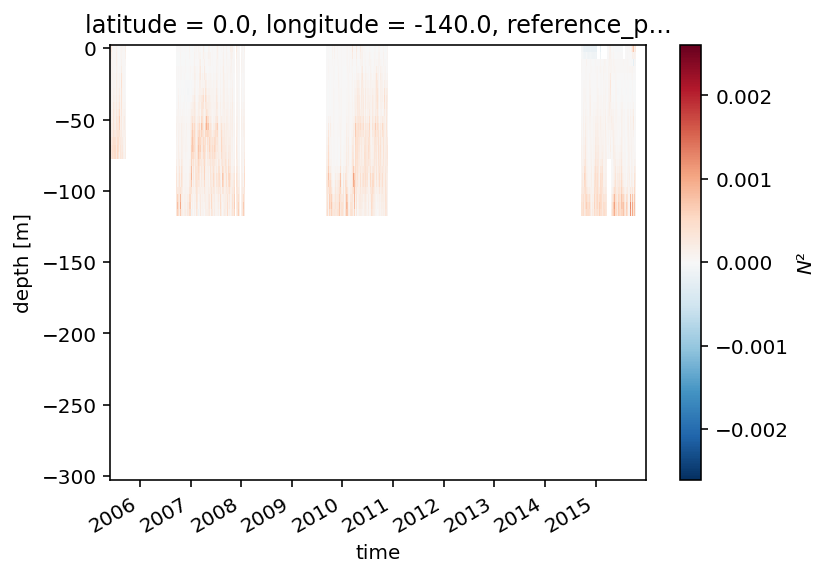

In [ ]:
tao_gridded.N2.cf.plot()

<matplotlib.collections.QuadMesh>

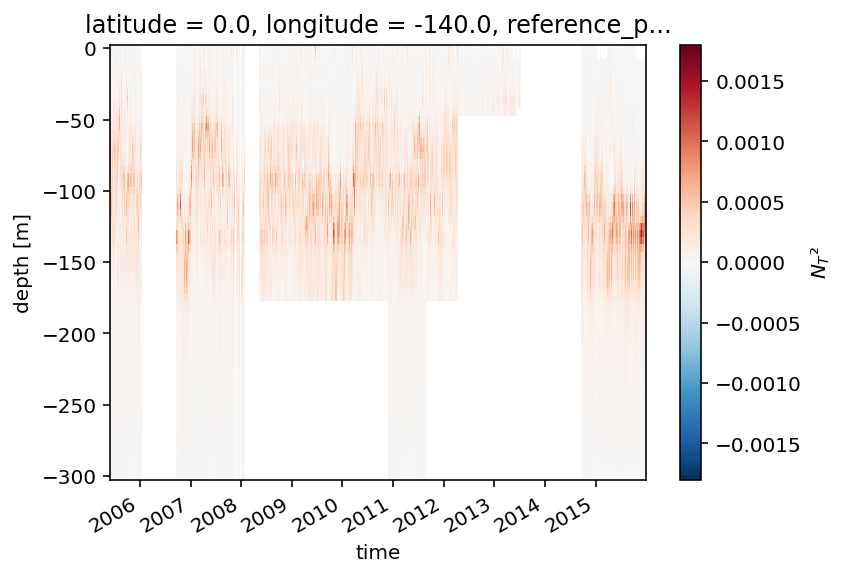

In [ ]:
tao_gridded.N2T.cf.plot()

## PDFs change 

(-4.5, -2.5)

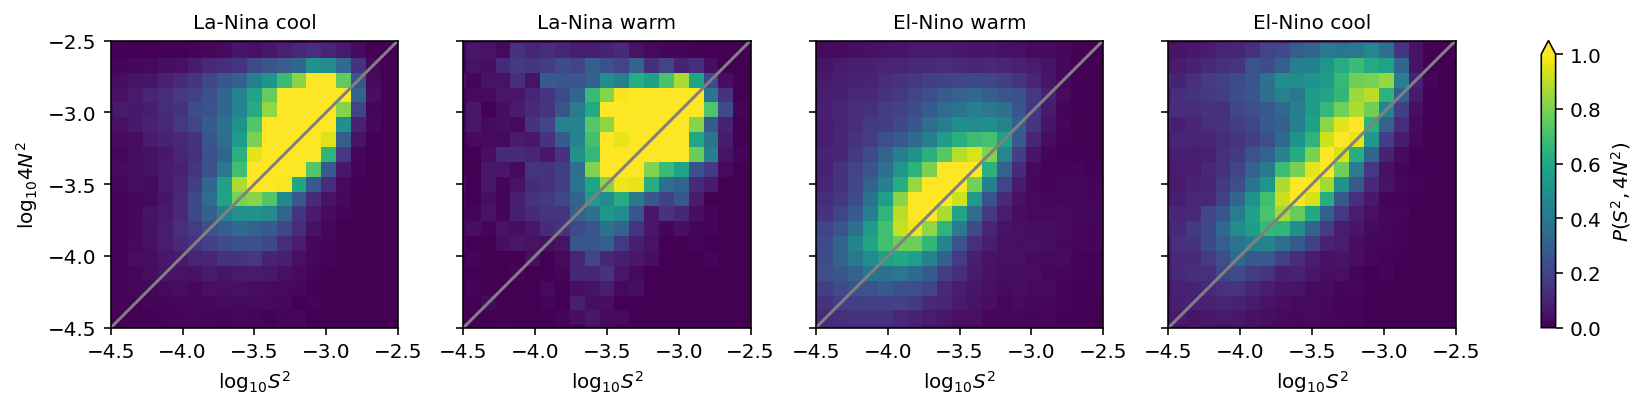

In [ ]:
fg = tao_gridded.n2s2pdf.sel(
    enso_transition_phase=[
        "La-Nina cool",
        "La-Nina warm",
        "El-Nino warm",
        "El-Nino cool",
    ]
).plot(vmax=1, col="enso_transition_phase")
fg.set_titles("{value}")
fg.map(dcpy.plots.line45)
fg.axes[0, 0].set_xlim((-4.5, -2.5))
fg.axes[0, 0].set_ylim((-4.5, -2.5))

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

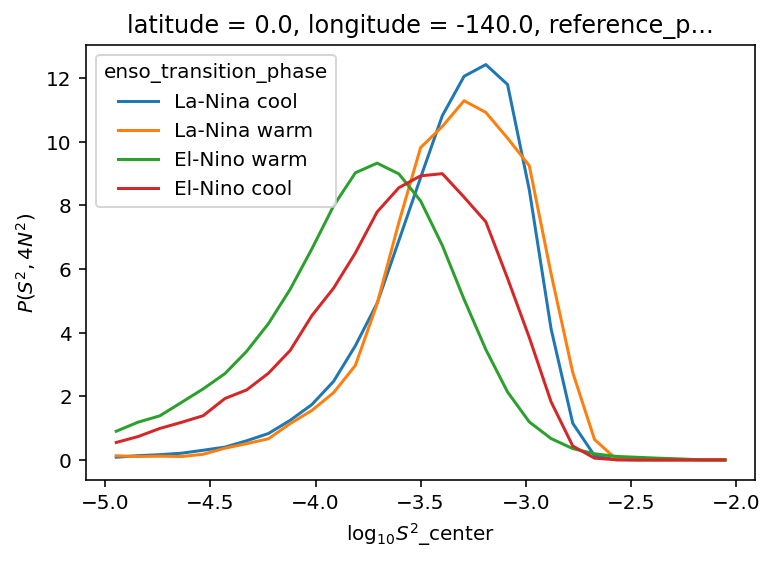

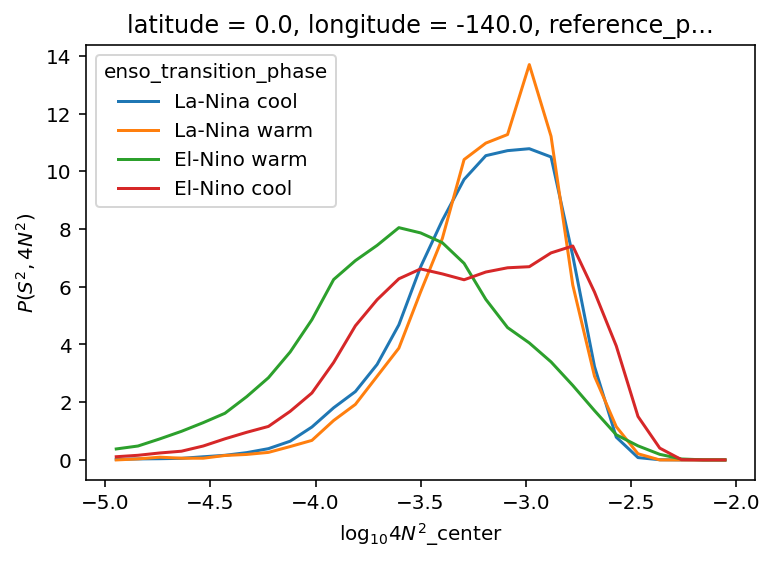

In [ ]:
(
    tao_gridded.n2s2pdf.sel(
        enso_transition_phase=[
            "La-Nina cool",
            "La-Nina warm",
            "El-Nino warm",
            "El-Nino cool",
        ]
    )
    .sum("N2_bins")
    .plot(hue="enso_transition_phase")
)
plt.figure()
(
    tao_gridded.n2s2pdf.sel(
        enso_transition_phase=[
            "La-Nina cool",
            "La-Nina warm",
            "El-Nino warm",
            "El-Nino cool",
        ]
    )
    .sum("S2_bins")
    .plot(hue="enso_transition_phase")
)

(-4.5, -2.5)

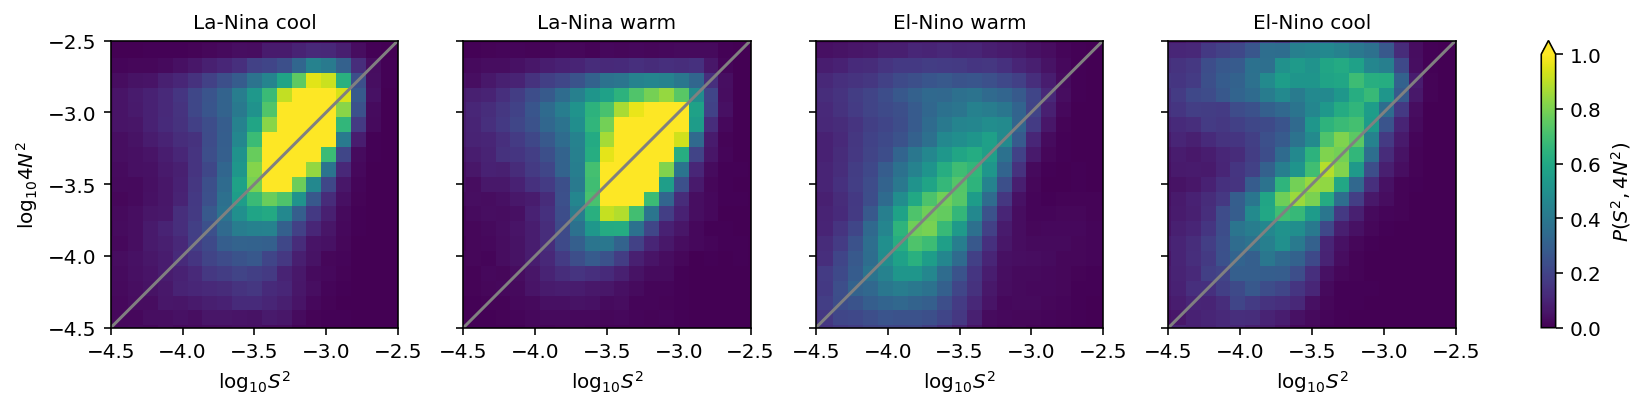

In [ ]:
fg = tao_gridded.n2s2Tpdf.sel(
    enso_transition_phase=[
        "La-Nina cool",
        "La-Nina warm",
        "El-Nino warm",
        "El-Nino cool",
    ]
).plot(vmax=1, col="enso_transition_phase")
fg.set_titles("{value}")
fg.map(dcpy.plots.line45)
fg.axes[0, 0].set_xlim((-4.5, -2.5))
fg.axes[0, 0].set_ylim((-4.5, -2.5))

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

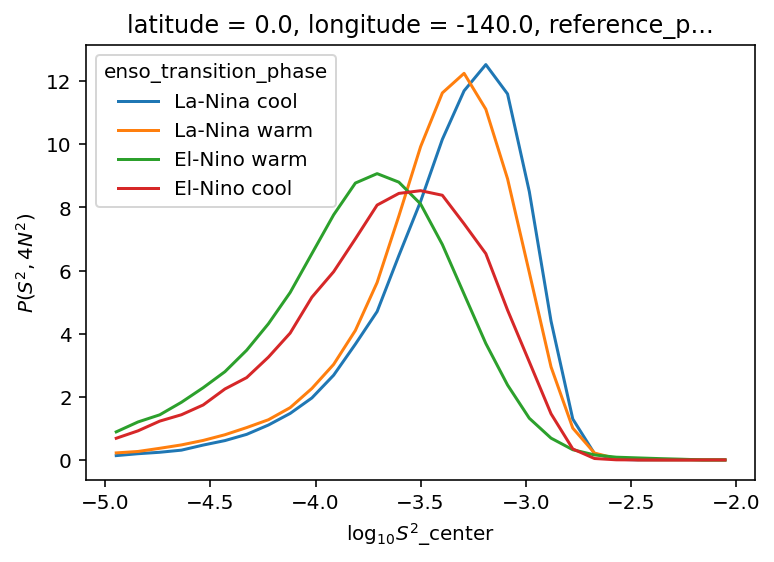

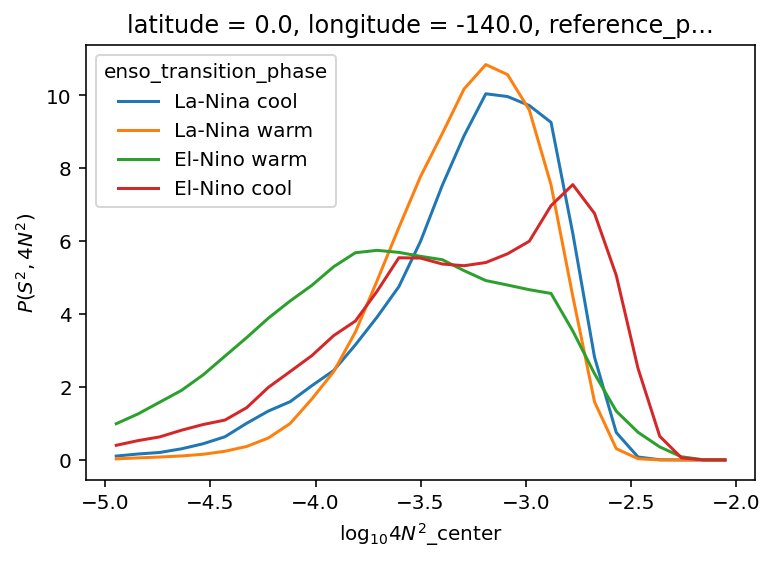

In [ ]:
(
    tao_gridded.n2s2Tpdf.sel(
        enso_transition_phase=[
            "La-Nina cool",
            "La-Nina warm",
            "El-Nino warm",
            "El-Nino cool",
        ]
    )
    .sum("N2_bins")
    .plot(hue="enso_transition_phase")
)
plt.figure()
(
    tao_gridded.n2s2Tpdf.sel(
        enso_transition_phase=[
            "La-Nina cool",
            "La-Nina warm",
            "El-Nino warm",
            "El-Nino cool",
        ]
    )
    .sum("S2_bins")
    .plot(hue="enso_transition_phase")
)